## Dynamic Customer Segmentation using LRFMS & Time Series Clustering
This notebook implements the methodology described in the research paper 'A dynamic customer segmentation approach by combining LRFMS and multivariate time series clustering'. We will use a real-world transaction dataset to segment customers based on their behavior over time.

###  Project Workflow:
* **Setup & Data Loading:** Import libraries and load the datasets.

* **Data Preparation:** Merge and clean the data to create an analytical base table.

* **Time Series Aggregation:** Convert the transaction log into a time series format for each customer.

LRFMS Feature Engineering: Calculate the Length, Recency, Frequency, Monetary, and Satisfaction metrics for each time period.

Multivariate Time Series Clustering: Apply clustering algorithms to segment the customers.

Analysis & Visualization: Analyze the resulting clusters and visualize their behavior.

Step 1: Setup & Data Loading
Explanation
Before we begin, we need to set up our environment. This involves two parts:

Installing Libraries: We need tslearn, a powerful library specifically designed for time series analysis and clustering in Python. We install it quietly using !pip install tslearn -q.

Importing Packages: We import pandas and numpy for data manipulation, plotly for creating interactive visualizations, and key components from sklearn and tslearn for our machine learning tasks.

Finally, we load the three CSV files (Transactions_Cleaned.csv, CustomerDemographic_Cleaned.csv, CustomerAddress_Cleaned.csv) into pandas DataFrames, which are essentially tables that make the data easy to work with. A try-except block is used to handle potential errors if the files aren't found.

In [3]:
%pip install tslearn

import pandas as pd
import numpy as np
from datetime import datetime

# For clustering and evaluation
import tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.metrics import silhouette_score

# For visualization
import plotly.graph_objects as go
import plotly.express as px

# --- Load the Datasets ---
try:
    transactions_df = pd.read_csv('Transactions_Cleaned.csv')
    demographics_df = pd.read_csv('CustomerDemographic_Cleaned.csv')
    address_df = pd.read_csv('CustomerAddress_Cleaned.csv')
    print("All datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Make sure the CSVs are in the current directory.")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\satav\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


All datasets loaded successfully!


Step 2: Data Preparation
Explanation
Our data is currently spread across three separate files. To analyze it effectively, we need to combine it into a single, master table using pd.merge().

We will then select only the columns needed for our LRFM analysis (customer_id, transaction_date, list_price). This clean, focused table is our Analytical Base Table (ABT).

In [4]:
# Merge datasets to get a master table
merged_df = pd.merge(transactions_df, demographics_df, on='customer_id', how='left')
master_df = pd.merge(merged_df, address_df, on='customer_id', how='left')

# Convert transaction_date to datetime
master_df['transaction_date'] = pd.to_datetime(master_df['transaction_date'])

# Create the final analytical base table for LRFM
abt = master_df[['customer_id', 'transaction_date', 'list_price']]
abt = abt.rename(columns={'list_price': 'monetary_value'})
abt.dropna(inplace=True)

print("Data preparation complete. Here is a preview of the Analytical Base Table:")
abt.head()

Data preparation complete. Here is a preview of the Analytical Base Table:


,customer_id,transaction_date,monetary_value
0,2950,2017-02-25,71.49
1,3120,2017-05-21,2091.47
2,402,2017-10-16,1793.43
3,3135,2017-08-31,1198.46
4,787,2017-10-01,1765.30


Step 3: Time Series Aggregation
Explanation
The LRFM model analyzes behavior over time. We convert our transaction log into a time series by grouping data into monthly bins using .resample('M'). For each customer in each month, we calculate:

frequency: The count of transactions.

monetary: The sum of all purchase values.

This gives us a time series view of F and M for every customer.

In [5]:
# Set transaction_date as the index for time-based operations
abt_indexed = abt.set_index('transaction_date')

# Group by customer_id and resample into monthly bins
time_series_df = abt_indexed.groupby('customer_id').resample('M').agg(
    frequency=('customer_id', 'size'),
    monetary=('monetary_value', 'sum')
).reset_index()

# Resampling creates a row for every month, even with no transactions.
# Fill months with no activity with 0 for frequency and monetary.
time_series_df[['frequency', 'monetary']] = time_series_df[['frequency', 'monetary']].fillna(0)

print("Time series aggregation complete. Preview:")
time_series_df.head()

C:\Users\satav\AppData\Local\Temp\ipykernel_4000\216256216.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_series_df = abt_indexed.groupby('customer_id').resample('M').agg(


Time series aggregation complete. Preview:


,customer_id,transaction_date,frequency,monetary
0,1,2017-01-31,1,360.40
1,1,2017-02-28,1,71.49
2,1,2017-03-31,2,1963.56
3,1,2017-04-30,1,1577.53
4,1,2017-05-31,2,3259.69


Step 4: LRFM Feature Engineering

Explanation

With our data in a monthly time series, we can now engineer the final LRFM features. F and M are already done. We now calculate Length (L) and Recency (R'):



Length (L): Measures customer tenure. It's the number of days between their first purchase and their last purchase within the current monthly period.

Recency (R'): Measures recent activity. It's the number of days between the end of the month and their last purchase in that month.

We calculate these and add them as new columns to complete our LRFM feature set.

In [6]:
# Calculate the very first purchase date for each customer
first_purchase = abt.groupby('customer_id')['transaction_date'].min().reset_index()
first_purchase.rename(columns={'transaction_date': 'first_purchase_date'}, inplace=True)

# Calculate the last purchase date within each month for each customer
# FIX: Using a more stable groupby().agg() approach to avoid version-specific errors.
abt['transaction_month'] = abt['transaction_date'].dt.to_period('M').dt.start_time
last_purchase_in_period = abt.groupby(['customer_id', 'transaction_month'])['transaction_date'].max().reset_index()
last_purchase_in_period.rename(columns={'transaction_date': 'last_purchase_date', 'transaction_month': 'transaction_date'}, inplace=True)

# Merge these helper calculations back into the main time series dataframe
ts_final = pd.merge(time_series_df, first_purchase, on='customer_id', how='left')
ts_final = pd.merge(ts_final, last_purchase_in_period, on=['customer_id', 'transaction_date'], how='left')

# --- Calculate L and R' in days --- #
# Forward-fill the last purchase date for months where there were no purchases
ts_final['last_purchase_date'] = ts_final.groupby('customer_id')['last_purchase_date'].ffill()

ts_final['length'] = (ts_final['last_purchase_date'] - ts_final['first_purchase_date']).dt.days
ts_final['recency'] = (ts_final['transaction_date'].dt.to_period('M').dt.end_time - ts_final['last_purchase_date']).dt.days

# Handle NaNs that arise (e.g. for the very first month) by filling them with 0
ts_final.fillna(0, inplace=True)

# Select final features for clustering
features = ['length', 'recency', 'frequency', 'monetary']
final_lrfm_df = ts_final[['customer_id', 'transaction_date'] + features]

print("LRFM Feature Engineering complete. Final dataset preview:")
final_lrfm_df.head()

LRFM Feature Engineering complete. Final dataset preview:


C:\Users\satav\AppData\Local\Temp\ipykernel_4000\2090517795.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  ts_final.fillna(0, inplace=True)
C:\Users\satav\AppData\Local\Temp\ipykernel_4000\2090517795.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ts_final.fillna(0, inplace=True)


,customer_id,transaction_date,length,recency,frequency,monetary
0,1,2017-01-31,0.0,0.0,1,360.40
1,1,2017-02-28,0.0,0.0,1,71.49
2,1,2017-03-31,0.0,0.0,2,1963.56
3,1,2017-04-30,0.0,0.0,1,1577.53
4,1,2017-05-31,0.0,0.0,2,3259.69


Step 5: Multivariate Time Series Clustering
Explanation
This is the core machine learning step. The tslearn library requires data in a 3D shape: (number_of_customers, number_of_timesteps, number_of_features). We use .pivot() and .reshape() to transform our table into this 3D array.

Before clustering, we scale the data using TimeSeriesScalerMinMax. This is crucial because features like monetary can have large values that would otherwise dominate the algorithm. Scaling brings all features into a 0-to-1 range.

We then find the optimal number of clusters (k) by calculating the Silhouette Score for several values of k. The highest score indicates the best-defined clusters. Finally, we run TimeSeriesKMeans with the optimal k to get our final segments. We use the "dtw" (Dynamic Time Warping) metric, which is excellent for comparing time series.

In [7]:
# Pivot the table to prepare for reshaping
pivoted_df = final_lrfm_df.pivot(index='customer_id', columns='transaction_date', values=features)
pivoted_df.fillna(0, inplace=True) # Fill NaNs for customers who joined later

# Reshape data into a 3D NumPy array (n_customers, n_timesteps, n_features)
n_customers = len(pivoted_df.index)
n_timesteps = len(final_lrfm_df['transaction_date'].unique())
n_features = len(features)
data_array = pivoted_df.values.reshape(n_customers, n_timesteps, n_features)

# Scale the features
scaler = TimeSeriesScalerMinMax()
scaled_data = scaler.fit_transform(data_array)
print(f"Data reshaped and scaled. Shape: {scaled_data.shape}")


# --- SPEED UP: Create a sample for finding the optimal k ---
sample_size = 800
# Ensure sample size is not larger than the number of customers
if sample_size > n_customers:
    sample_size = n_customers

np.random.seed(42) # for reproducibility
sample_indices = np.random.choice(n_customers, sample_size, replace=False)
data_sample = scaled_data[sample_indices]
print(f"Created a sample of {sample_size} customers to find optimal k.")


# --- Find the optimal number of clusters (k) on the SAMPLE --- #
print("\nFinding optimal number of clusters (k) on the sample...")
silhouette_scores = {}
# Reshape sample data for silhouette score evaluation (needs 2D)
reshaped_sample_for_eval = data_sample.reshape(sample_size, -1) 

for k in range(2, 6): # Test k from 2 to 5 (reduced range for speed)
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=5, random_state=42, n_jobs=-1)
    labels = model.fit_predict(data_sample)
    score = silhouette_score(reshaped_sample_for_eval, labels)
    silhouette_scores[k] = score
    print(f"k={k}, Silhouette Score: {score:.4f}")

optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nOptimal k found from sample: {optimal_k}")


# --- Final Clustering on the FULL dataset --- #
print(f"\nRunning final clustering with k={optimal_k} on the full dataset...")
final_model = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw", max_iter=10, random_state=42, n_jobs=-1)
final_labels = final_model.fit_predict(scaled_data) # Use the full 'scaled_data'

# Add cluster labels back to our customer list
customer_clusters = pd.DataFrame({'customer_id': pivoted_df.index, 'cluster': final_labels})
print("\nClustering complete.")
customer_clusters.head()


Data reshaped and scaled. Shape: (3494, 12, 4)
Created a sample of 800 customers to find optimal k.

Finding optimal number of clusters (k) on the sample...
k=2, Silhouette Score: 0.0734
k=3, Silhouette Score: 0.0674
k=4, Silhouette Score: 0.0663
k=5, Silhouette Score: 0.0546

Optimal k found from sample: 2

Running final clustering with k=2 on the full dataset...

Clustering complete.


,customer_id,cluster
0,1,1
1,2,0
2,3,1
3,4,0
4,5,1


Step 6: Analysis & Visualization
Explanation
Now that we have assigned each customer to a cluster, the final step is to understand what these clusters represent.

To interpret the clusters, we calculate the average value for each of the LRFM features within each cluster using groupby('cluster').mean(). This gives us a cluster summary table that reveals the defining characteristics of each segment (e.g., high monetary value, high frequency).

To bring this to life, we visualize the average monthly spend (monetary) for each cluster over time. This line chart is the most powerful output of our project, as it clearly shows the different behavioral patterns of our customer segments, allowing us to give them meaningful names like "Loyal High Spenders" or "At-Risk Customers".

In [8]:
# Merge cluster labels with the full LRFM time series data
analysis_df = pd.merge(final_lrfm_df, customer_clusters, on='customer_id')

# --- Visualize the Cluster Trends --- #
# Calculate the average monetary value for each cluster over time
cluster_trends = analysis_df.groupby(['cluster', 'transaction_date'])['monetary'].mean().reset_index()

fig = px.line(
    cluster_trends, 
    x='transaction_date', 
    y='monetary', 
    color='cluster', 
    title='Average Monthly Spend per Customer Cluster',
    labels={'monetary': 'Average Monetary Value', 'transaction_date': 'Date', 'cluster': 'Customer Cluster'}
)
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Average Spend',
    legend_title='Cluster',
    font=dict(family="Arial, sans-serif", size=12)
)
fig.show()

# --- Analyze Cluster Characteristics --- #
# Calculate the average LRFM values and customer count for each cluster
cluster_summary = analysis_df.groupby('cluster')[features].mean().round(2)
cluster_summary['customer_count'] = analysis_df.groupby('cluster')['customer_id'].nunique()

print("\n--- Cluster Summary Statistics (Average LRFM values) ---")
cluster_summary



--- Cluster Summary Statistics (Average LRFM values) ---


,length,recency,frequency,monetary,customer_count
cluster,,,,,
0,0.0,0.0,0.61,674.17,1878
1,0.0,0.0,0.69,759.11,1616


Step 7: Forecasting Future Customer Spend
Explanation
Now that we understand the historical behavior of our customer segments, the next logical step is to predict their future value. We will use a forecasting model to predict the average monthly spend for each cluster for the next 6 months.

For this task, we'll use Prophet, a powerful and user-friendly forecasting library developed by Facebook. It's excellent at handling time series data with trends and seasonality.

The process is as follows:

Install Prophet: Add the necessary library.

Loop Through Each Cluster: For each customer segment, we will train a separate forecasting model.

Prepare Data: Prophet requires the data to be in a specific format with two columns: ds (for the date) and y (for the value we want to predict).

Train and Predict: We'll train the model on the historical spending data and then ask it to predict the next 6 months.

Visualize Forecast: We will combine the historical data with the new forecast and plot it, including an "uncertainty interval" which shows the likely range of future spending.


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
20:15:04 - cmdstanpy - INFO - Chain [1] start processing
20:15:04 - cmdstanpy - INFO - Chain [1] done processing



--- Forecasting Future Spend for Each Cluster ---


c:\Users\satav\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\forecaster.py:1872: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



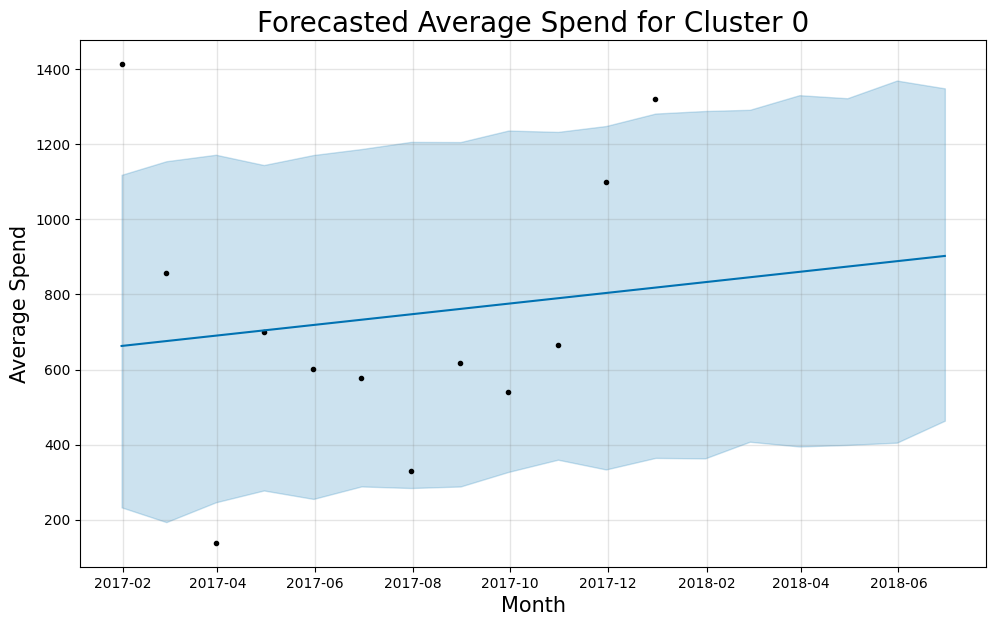

20:15:04 - cmdstanpy - INFO - Chain [1] start processing
20:15:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\satav\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\forecaster.py:1872: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



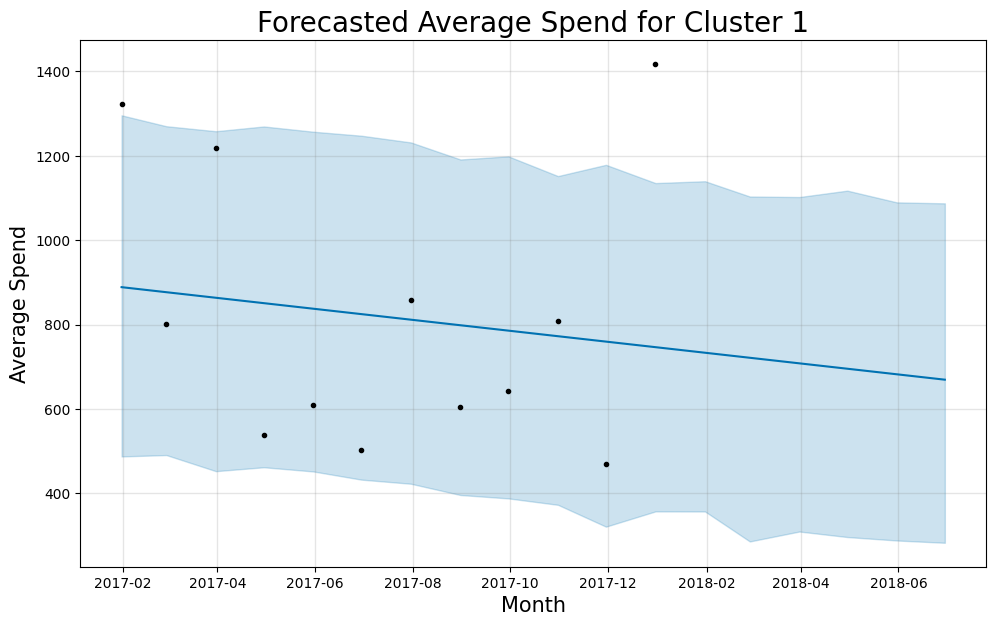

In [10]:
# Install the forecasting library. You may need to restart the kernel after this.
!pip install prophet
import matplotlib.pyplot as plt
from prophet import Prophet

# --- Create a plot for each cluster's forecast ---
print("\n--- Forecasting Future Spend for Each Cluster ---")

# Get the unique cluster labels
clusters = analysis_df['cluster'].unique()
clusters.sort()

for cluster_id in clusters:
    # Get the historical data for this specific cluster
    cluster_data = cluster_trends[cluster_trends['cluster'] == cluster_id]
    
    # 1. Prepare data for Prophet
    prophet_df = cluster_data[['transaction_date', 'monetary']].rename(columns={
        'transaction_date': 'ds',
        'monetary': 'y'
    })
    
    # 2. Train the Prophet model
    model = Prophet()
    model.fit(prophet_df)
    
    # 3. Create a dataframe for future predictions (next 6 months)
    future = model.make_future_dataframe(periods=6, freq='M')
    forecast = model.predict(future)
    
    # 4. Visualize the forecast
    fig = model.plot(forecast, xlabel='Date', ylabel='Average Spend')
    ax = fig.gca()
    ax.set_title(f'Forecasted Average Spend for Cluster {cluster_id}', size=20)
    ax.set_xlabel("Month", size=15)
    ax.set_ylabel("Average Spend", size=15)
    plt.show()